## 1. Quá trình dự báo trên mô hình ARIMA

Thêm thư viện

In [84]:
%matplotlib inline
import numpy as np
import pandas as pd
import pmdarima as pmd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRUV2 as GRU
from keras.models import load_model
import investpy
import datetime as dt

Nạp dữ liệu từ file csv

In [85]:

start = '01/06/2021'
end = dt.datetime.now().strftime("%d/%m/%Y")
stock='bitcoin'
df = investpy.get_crypto_historical_data(crypto=stock,from_date=start, to_date=end)
df = pd.DataFrame(df)
df.pop('Currency')
df.pop('Volume')
df.pop('High')
df.pop('Low')
df.pop('Open')
df_close = df['Close'].values.reshape(-1, 1)


df

,Close
Date,
2021-06-01,36687.6
2021-06-02,37555.8
2021-06-03,39187.3
2021-06-04,36851.3
2021-06-05,35520.0
...,...
2022-06-11,28403.4
2022-06-12,26606.3
2022-06-13,22448.0


Chuẩn hóa dữ liệu

In [86]:
arima_sc = MinMaxScaler()

df_scaled = df.copy()
df_scaled['Close'] = arima_sc.fit_transform(df_close)
df_scaled

,Close
Date,
2021-06-01,0.333599
2021-06-02,0.352359
2021-06-03,0.387613
2021-06-04,0.337136
2021-06-05,0.308369
...,...
2022-06-11,0.154593
2022-06-12,0.115761
2022-06-13,0.025908


Vẽ đồ thị

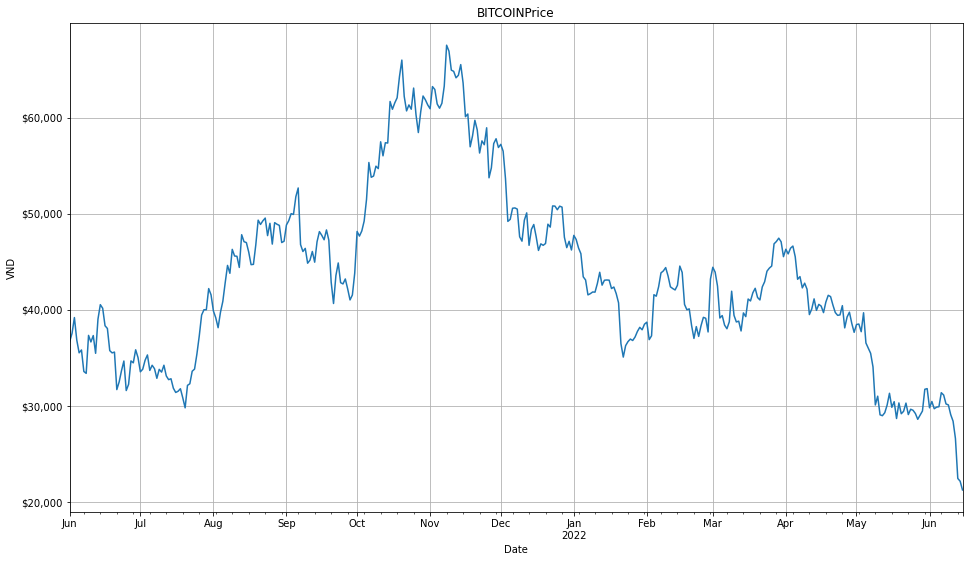

In [87]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = stock.upper()+'Price'
ylabel = 'VND'
xlabel = 'Date'

ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

Tách dữ liệu thành tập train và test

In [88]:
train, test = df_scaled[df_scaled.index < '2022-04-01'], df_scaled[df_scaled.index >= '2022-04-01']
index_test = df_scaled.index[df_scaled.index >= '2022-04-01']
print('train shape: ', train.shape)
print('test shape: ', test.shape)
print('test percent: ', len(test)/len(df_scaled))
print('train percent: ', len(train)/len(df_scaled))

train shape:  (304, 1)
test shape:  (76, 1)
test percent:  0.2
train percent:  0.8


Hàm kiểm định chuỗi dừng

In [89]:
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    # .dropna() handles differenced data
    result = adfuller(series.dropna(), autolag='AIC')

    labels = ['ADF test statistic', 'p-value',
              'Number of lags used', 'Number of observations']
    out = pd.Series(result[0:4], index=labels)

    for key, val in result[4].items():
        out[f'critical value ({key})'] = val

    # .to_string() removes the line "dtype: float64"
    print(out.to_string())

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non stationary")

Kiểm định tính dừng của chuỗi

In [90]:
adf_test(train['Close'],'Bitcoin Price')

Augmented Dickey-Fuller Test: Bitcoin Price
ADF test statistic         -1.533405
p-value                     0.516926
Number of lags used         2.000000
Number of observations    301.000000
critical value (1%)        -3.452263
critical value (5%)        -2.871191
critical value (10%)       -2.571912
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non stationary


nhận thấy p-value > 0.05, do đó chuỗi không phải là chuỗi dừng

Tính sai phân bậc 1 (d = 1) của chuỗi để kiểm định tính dừng

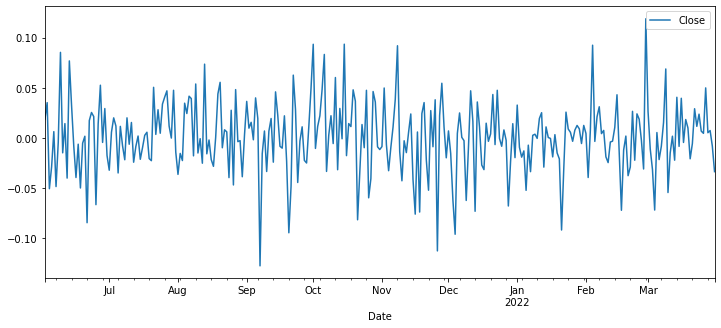

In [91]:
diff_1 = train.diff().dropna()
diff_1.plot(figsize=(12,5));

Kiểm định tính dừng của chuỗi tại sai phân bậc 1

In [92]:
adf_test(diff_1, 'Bitcoin Price First Difference')

Augmented Dickey-Fuller Test: Bitcoin Price First Difference
ADF test statistic       -1.378871e+01
p-value                   9.010116e-26
Number of lags used       1.000000e+00
Number of observations    3.010000e+02
critical value (1%)      -3.452263e+00
critical value (5%)      -2.871191e+00
critical value (10%)     -2.571912e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Nhận thấy p-value < 0.05, do đó chuỗi có tính dừng tại sai phân bậc 1

In [93]:

def ArimaModel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              test="adf",
                              seasonal=False,
                              trace=True)
    return autoarima_model

In [94]:
arima_model = ArimaModel(train)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1164.438, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1163.182, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1161.249, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1161.272, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1165.085, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1160.397, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.906 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  304
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 583.543
Date:                Wed, 15 Jun 2022   AIC                          -1165.085
Time:                        22:20:22   BIC                          -1161.371
Sample:                             0   HQIC                         -1163.599
                                - 304                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   7.99e-05     15.555      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                19.53
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.15
Prob(H) (two-sided):                  0.32   Kurtosis:                         4.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Dự đoán trên tập test

In [95]:
pred = arima_model.predict(len(test))
pred


array([0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455871,
       0.52455871, 0.52455871, 0.52455871, 0.52455871, 0.52455

Biến đổi giá trị dự đoán và thực tế về miền giá trị ban đầu

In [96]:
inv_test = arima_sc.inverse_transform(test.values.reshape(-1, 1))
inv_pred = arima_sc.inverse_transform(column_or_1d(pred).reshape(-1, 1))

Vẽ đồ thị cho tập test và kết quả dự đoán

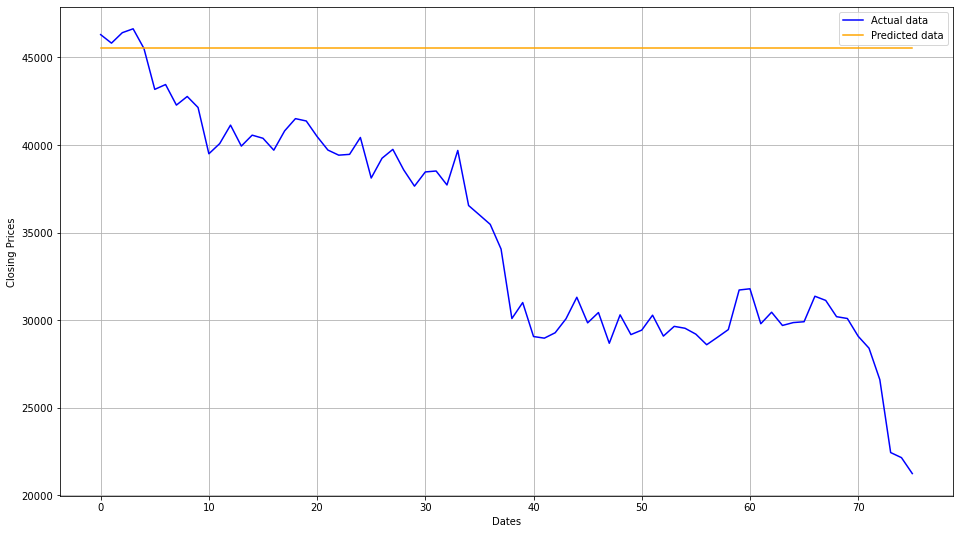

In [97]:
pred_series = pd.Series(pred, index=index_test)

plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(inv_test, 'blue', label='Actual data')
plt.plot(inv_pred, 'orange', label='Predicted data')
plt.legend()

Đánh giá mô hình

In [98]:
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 10772.49
MAPE: 35.33%
MSE: 153455242.16
RMSE: 12387.71


Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình ARIMA

In [99]:
df_pred = pd.DataFrame(index=index_test)
df_pred['Actual'] = inv_test
df_pred['ARIMA'] = inv_pred
df_pred['Error'] = inv_test - inv_pred
df_pred

,Actual,ARIMA,Error
Date,,,
2022-04-01,46297.0,45525.0,772.0
2022-04-02,45811.0,45525.0,286.0
2022-04-03,46407.0,45525.0,882.0
2022-04-04,46629.0,45525.0,1104.0
2022-04-05,45506.0,45525.0,-19.0
...,...,...,...
2022-06-11,28403.4,45525.0,-17121.6
2022-06-12,26606.3,45525.0,-18918.7
2022-06-13,22448.0,45525.0,-23077.0


## 2. Quá trình dự đoán trên mô hình GRU

Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình GRU

In [100]:
df_gru = df_pred.copy()
df_gru

,Actual,ARIMA,Error
Date,,,
2022-04-01,46297.0,45525.0,772.0
2022-04-02,45811.0,45525.0,286.0
2022-04-03,46407.0,45525.0,882.0
2022-04-04,46629.0,45525.0,1104.0
2022-04-05,45506.0,45525.0,-19.0
...,...,...,...
2022-06-11,28403.4,45525.0,-17121.6
2022-06-12,26606.3,45525.0,-18918.7
2022-06-13,22448.0,45525.0,-23077.0


Vẽ đồ thị thể hiện sai số

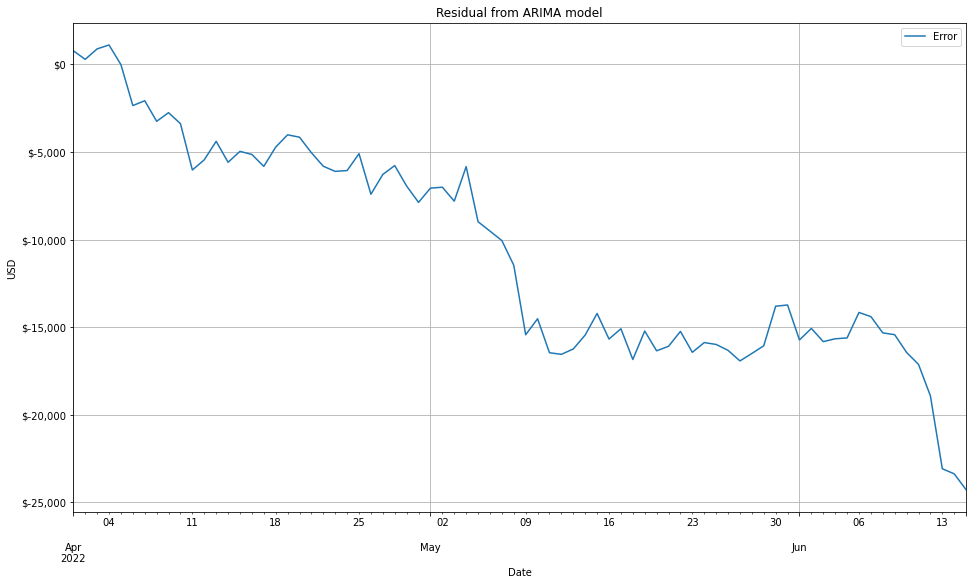

In [101]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_gru[['Error']]
title = 'Residual from ARIMA model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [102]:
error = np.array(error)
error

array([[ 7.72000e+02],
       [ 2.86000e+02],
       [ 8.82000e+02],
       [ 1.10400e+03],
       [-1.90000e+01],
       [-2.35200e+03],
       [-2.07700e+03],
       [-3.25000e+03],
       [-2.75800e+03],
       [-3.38700e+03],
       [-6.02800e+03],
       [-5.44700e+03],
       [-4.39200e+03],
       [-5.58900e+03],
       [-4.96500e+03],
       [-5.14300e+03],
       [-5.82200e+03],
       [-4.72200e+03],
       [-4.02200e+03],
       [-4.15700e+03],
       [-5.04300e+03],
       [-5.81600e+03],
       [-6.10700e+03],
       [-6.06100e+03],
       [-5.09800e+03],
       [-7.41200e+03],
       [-6.28200e+03],
       [-5.77700e+03],
       [-6.94400e+03],
       [-7.87500e+03],
       [-7.06400e+03],
       [-7.01100e+03],
       [-7.80700e+03],
       [-5.83700e+03],
       [-8.98100e+03],
       [-9.51600e+03],
       [-1.00570e+04],
       [-1.14650e+04],
       [-1.54300e+04],
       [-1.45175e+04],
       [-1.64568e+04],
       [-1.65490e+04],
       [-1.62406e+04],
       [-1.

In [103]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (73, 3, 1)
y_train (73, 1)


In [104]:
# define model
model = Sequential()
model.add(GRU(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(GRU(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save(f"{stock}.h5")

Epoch 1/300
3/3 [==============================] - 2s 3ms/step - loss: 162186720.0000
Epoch 2/300
3/3 [==============================] - 0s 3ms/step - loss: 156374064.0000
Epoch 3/300
3/3 [==============================] - 0s 4ms/step - loss: 152982416.0000
Epoch 4/300
3/3 [==============================] - 0s 4ms/step - loss: 149808176.0000
Epoch 5/300
3/3 [==============================] - 0s 4ms/step - loss: 147092432.0000
Epoch 6/300
3/3 [==============================] - 0s 5ms/step - loss: 144404720.0000
Epoch 7/300
3/3 [==============================] - 0s 6ms/step - loss: 139363264.0000
Epoch 8/300
3/3 [==============================] - 0s 5ms/step - loss: 135128912.0000
Epoch 9/300
3/3 [==============================] - 0s 4ms/step - loss: 130895960.0000
Epoch 10/300
3/3 [==============================] - 0s 3ms/step - loss: 126410104.0000
Epoch 11/300
3/3 [==============================] - 0s 4ms/step - loss: 121906320.0000
Epoch 12/300
3/3 [==============================] - 

In [73]:
model = load_model(f"{stock}.h5")
error_pred = model.predict(x_train)
error_pred

4/4 [==============================] - 0s 2ms/step


array([[ -3903.55   ],
       [ -3893.504  ],
       [ -4063.0764 ],
       [ -4785.3374 ],
       [ -5197.1597 ],
       [ -4575.7715 ],
       [ -2821.3455 ],
       [ -4761.5747 ],
       [ -4483.6304 ],
       [ -4447.1694 ],
       [ -5404.062  ],
       [ -3821.4158 ],
       [ -3974.0168 ],
       [ -2902.3872 ],
       [ -2329.3276 ],
       [ -1903.7616 ],
       [ -1429.4075 ],
       [ -1938.1952 ],
       [ -2306.0664 ],
       [ -1421.952  ],
       [   913.4087 ],
       [  1191.7185 ],
       [  1357.92   ],
       [  1257.7043 ],
       [  3941.1401 ],
       [  4799.54   ],
       [  3258.8005 ],
       [  2857.7112 ],
       [  2615.6409 ],
       [  2951.662  ],
       [  2237.8691 ],
       [  3457.8928 ],
       [  2871.4429 ],
       [  1165.0991 ],
       [   201.57542],
       [  -937.3511 ],
       [  -428.66486],
       [ -1058.8021 ],
       [ -1334.3417 ],
       [ -3407.9495 ],
       [ -3282.3806 ],
       [ -2786.314  ],
       [ -3207.9424 ],
       [ -2

In [74]:
df_gru = df_gru.copy().head(len(error_pred))
df_gru['Error Prediction'] = error_pred
df_gru

,Actual,ARIMA,Error,Error Prediction
Date,,,,
2022-03-01,44420.3,43188.2,1232.1,-3903.550049
2022-03-02,43912.8,43188.2,724.6,-3893.503906
2022-03-03,42463.0,43188.2,-725.2,-4063.076416
2022-03-04,39142.7,43188.2,-4045.5,-4785.337402
2022-03-05,39395.8,43188.2,-3792.4,-5197.159668
...,...,...,...,...
2022-06-08,30201.6,43188.2,-12986.6,-14254.252930
2022-06-09,30097.8,43188.2,-13090.4,-14973.151367
2022-06-10,29083.3,43188.2,-14104.9,-16712.162109


In [75]:
df_gru['ARIMA_GRU'] = df_gru['ARIMA'] + df_gru['Error Prediction']
df_gru

,Actual,ARIMA,Error,Error Prediction,ARIMA_GRU
Date,,,,,
2022-03-01,44420.3,43188.2,1232.1,-3903.550049,39284.649951
2022-03-02,43912.8,43188.2,724.6,-3893.503906,39294.696094
2022-03-03,42463.0,43188.2,-725.2,-4063.076416,39125.123584
2022-03-04,39142.7,43188.2,-4045.5,-4785.337402,38402.862598
2022-03-05,39395.8,43188.2,-3792.4,-5197.159668,37991.040332
...,...,...,...,...,...
2022-06-08,30201.6,43188.2,-12986.6,-14254.252930,28933.947070
2022-06-09,30097.8,43188.2,-13090.4,-14973.151367,28215.048633
2022-06-10,29083.3,43188.2,-14104.9,-16712.162109,26476.037891


Vẽ đồ thị

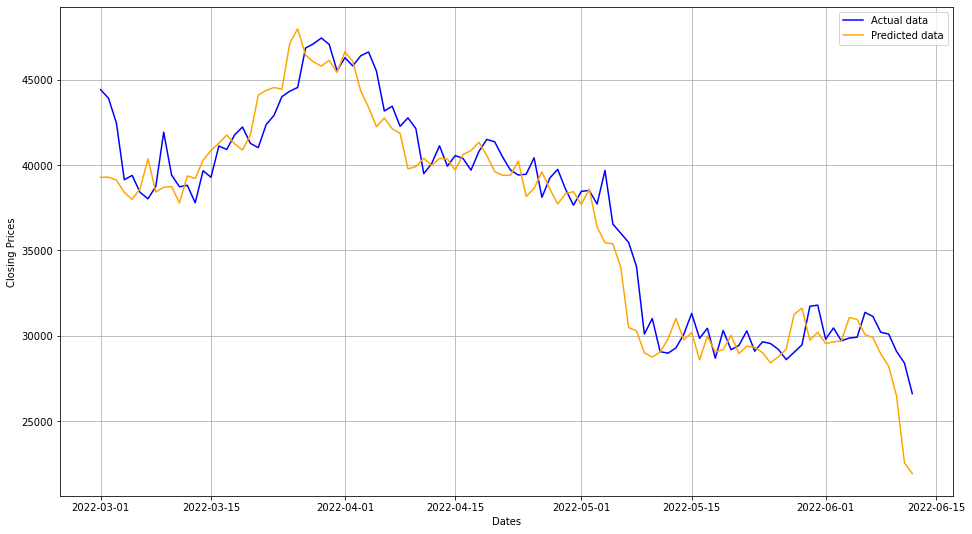

In [76]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_gru['Actual'], 'blue', label='Actual data')
plt.plot(df_gru['ARIMA_GRU'], 'orange', label='Predicted data')
plt.legend()

Đánh giá mô hình

In [77]:
mae = mean_absolute_error(df_gru.Actual, df_gru.ARIMA_GRU)
mape = mean_absolute_percentage_error(df_gru.Actual, df_gru.ARIMA_GRU)
mse = mean_squared_error(df_gru.Actual, df_gru.ARIMA_GRU)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1413.24
MAPE: 3.87%
MSE: 3514093.47
RMSE: 1874.59


Lấy 3 ngày cuối ra để dự báo

In [78]:
forecast = df_gru['Error'].tail(3)
forecast

Date
2022-06-10   -14104.9
2022-06-11   -14784.8
2022-06-12   -16581.9
Name: Error, dtype: float64

Đưa về ma trận

In [79]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-14104.9],
        [-14784.8],
        [-16581.9]]])

In [80]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

1/1 [==============================] - 0s 14ms/step


array([-16712.162], dtype=float32)

So sánh kết quả dự đoán với giá trị thực

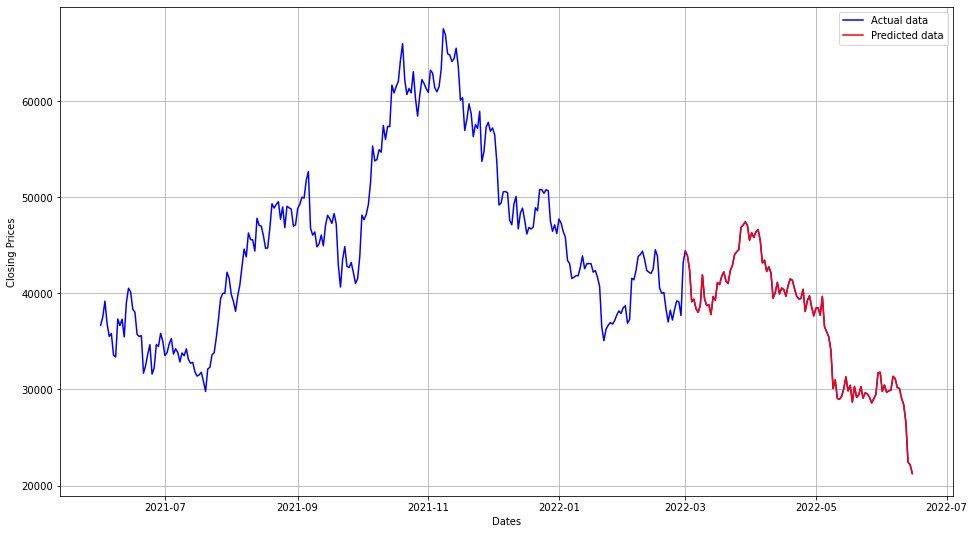

In [81]:
y_arima = df_pred.copy()
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = stock.upper()+'Price'
ylabel = 'USDT'
xlabel = 'Date'
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df['Close'], 'blue', label='Actual data')
plt.plot(y_arima['ARIMA']+y_arima['Error'], 'red', label='Predicted data')
plt.legend()


In [82]:

y_arima = y_arima.tail(1).head(1)
y_arima['Final_GRU'] = y_arima.ARIMA + y_forecast
y_arima

,Actual,ARIMA,Error,Final_GRU
Date,,,,
2022-06-15,21249.1,43188.2,-21939.1,26476.037891


Ghi ra file csv

In [83]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("ARIMA-PRED.csv")
df_gru.to_csv("GRU_PRED.csv")
y_arima.to_csv("Forecast.csv")